## VideoNeVA DataLoader

This notebook executes the Video DataLoader on a small subset of the raw data describing example usage. The raw data is stored on the Eos cluster at the following locations:

- Image Pretraining Dataset: `/lustre/fsw/coreai_dlalgo_llm/dataset/videoneva/image_pretrain`
- Image Instruction Tuning Dataset: `/lustre/fsw/coreai_dlalgo_llm/dataset/videoneva/image_instruction_tune`
- Video Pretraining Dataset: `/lustre/fsw/coreai_dlalgo_llm/dataset/videoneva/video_pretrain`
- Video Instruction Tuning Dataset: `/lustre/fsw/coreai_dlalgo_llm/dataset/videoneva/video_instruction_tune`


VideoNeVA implements a Video and Image DataLoader via the `TarOrFolderVideoLoader` and `TarOrFolderImageLoader` classes in `videoneva_dataset.py`:


The image dataloader is implemented as follows:


```


class TarOrFolderVideoLoader:
    """
    A class for loading images from a tar archive or a regular folder.

    This class provides functionality to open and read images from either a tar archive
    (.tar file) or a standard directory with image files. It builds an index of images
     if the source is a tar archive for efficient access.

    Attributes:
        image_folder (str): The path to the tar archive or video/image folder.
        tar_index (dict): A dictionary that maps file names to their tarfile member
                          objects if the video/image source is a tar archive.

    Methods:
        __init__(self, image_folder): Initializes the loader with the specified video/image folder.
        build_index(self): Builds an index of video/image file names and their corresponding
                           tarfile member objects for a tar archive.
        open_image(self, file_name): Opens and returns an image by its file name. The image
                                     is returned as an RGB PIL Image object.
        open_video(self, file_name): Opens and returns a video by its file name. The video
                                     is returned as an OpenCV VideoCapture object.
    """

    def __init__(self, video_folder):
        self.video_folder = video_folder
        self.tar_index = {}
        if self.video_folder.endswith('.tar'):
            self.build_index()

    def build_index(self):
        with tarfile.open(self.video_folder, 'r') as tar:
            for member in tar.getmembers():
                self.tar_index[member.name] = member

    def open_video(self, file_name):
        if self.video_folder.endswith('.tar'):
            with tarfile.open(self.video_folder, 'r') as tar:
                member = self.tar_index.get(file_name)
                if member:
                    f = tar.extractfile(member)
                    video_data = np.frombuffer(f.read(), dtype=np.uint8)
                    return cv2.imdecode(video_data, cv2.IMREAD_UNCHANGED)
        else:
            return cv2.VideoCapture(os.path.join(self.video_folder, file_name))
        return None

    def flatten_frames(self, cap, num_frames):

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        frames = []

        for index in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = cap.read()

            if not ret:
                print(f"Error: Could not read frame at index {index}.")
                break

            frames.append(frame)

        cap.release()
        frames_array = np.array(frames)

        return frames_array
```

The video dataloader is implemented as follows:


```
class TarOrFolderImageLoader:
    """
    A class for loading images and videos from a tar archive or a regular folder.

    This class provides functionality to open and read images and videos from either a tar archive
    (.tar file) or a standard directory with image or video files. It builds an index of images and
    videos if the source is a tar archive for efficient access.

    Attributes:
        visual_folder (str): The path to the tar archive or video/image folder.
        tar_index (dict): A dictionary that maps file names to their tarfile member
                          objects if the video/image source is a tar archive.

    Methods:
        __init__(self, image_folder): Initializes the loader with the specified video/image folder.
        build_index(self): Builds an index of video/image file names and their corresponding
                           tarfile member objects for a tar archive.
        open_image(self, file_name): Opens and returns an image by its file name. The image
                                     is returned as an RGB PIL Image object.
        open_video(self, file_name): Opens and returns a video by its file name. The video
                                     is returned as an OpenCV VideoCapture object.
    """

    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.tar_index = {}
        if self.image_folder.endswith('.tar'):
            self.build_index()

    def build_index(self):
        with tarfile.open(self.image_folder, 'r') as tar:
            for member in tar.getmembers():
                self.tar_index[member.name] = member

    def open_image(self, file_name):
        if self.image_folder.endswith('.tar'):
            with tarfile.open(self.image_folder, 'r') as tar:
                member = self.tar_index.get(file_name)
                if member:
                    f = tar.extractfile(member)
                    return Image.open(f).convert('RGB')
        else:
            return Image.open(os.path.join(self.image_folder, file_name)).convert('RGB')
        return None

```

---

## Example Usage

In [1]:
from videoneva_dataset import (
    TarOrFolderImageLoader,
    TarOrFolderVideoLoader,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

# define data paths
video_data_path = '/home/pmuthukumar/video_subset'
image_data_path = '/home/pmuthukumar/image_subset'
num_frames = 8 
batch_size = 8

#### Video DataLoader

In [2]:
video_data_loader = TarOrFolderVideoLoader(video_folder = video_data_path)

for fname in os.listdir(video_data_path):
    video_object = video_data_loader.open_video(video_data_path + fname)
    width = video_object.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = video_object.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = video_object.get(cv2.CAP_PROP_FPS)
    frames = video_object.get(cv2.CAP_PROP_FRAME_COUNT)
    print(type(video_object), " Video Resolution: ", width, " x ", height, ", FPS: ", fps)


<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  29.97
<class 'cv2.VideoCapture'>  Video Resolution:  446.0  x  336.0 , FPS:  25.0


In [5]:
for fname in os.listdir(video_data_path):
    video_object = video_data_loader.open_video(video_data_path + fname)
    frames = video_data_loader.flatten_frames(video_object, num_frames)
    print(type(frames), " Shape: ", frames.shape)

<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)
<class 'numpy.ndarray'>  Shape:  (8, 336, 446, 3)


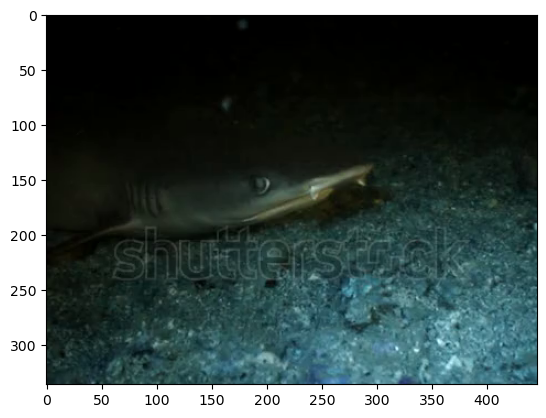

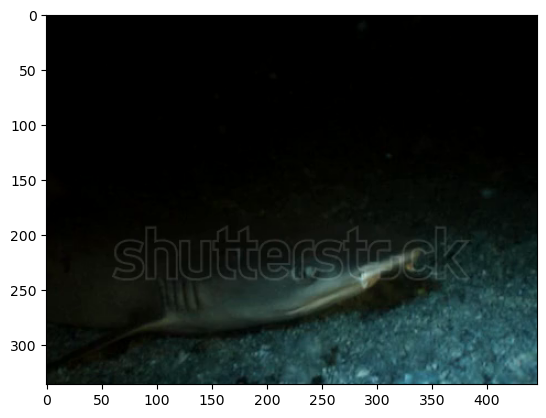

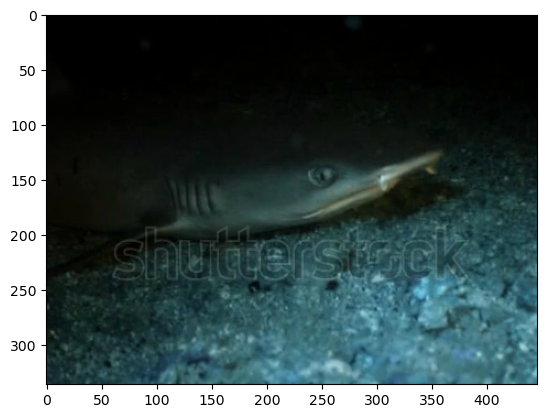

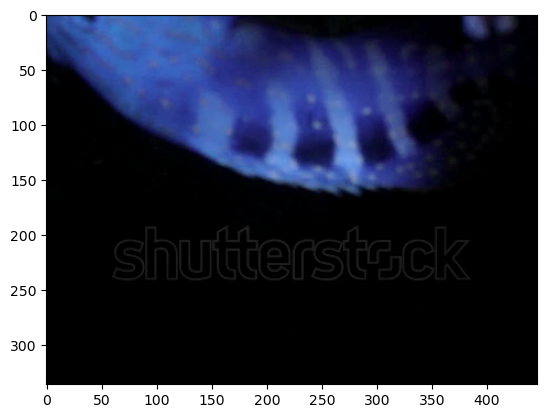

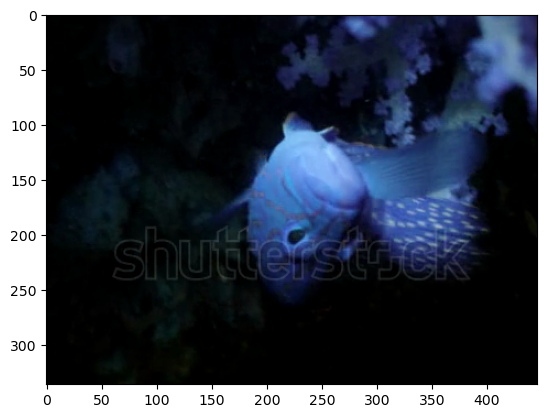

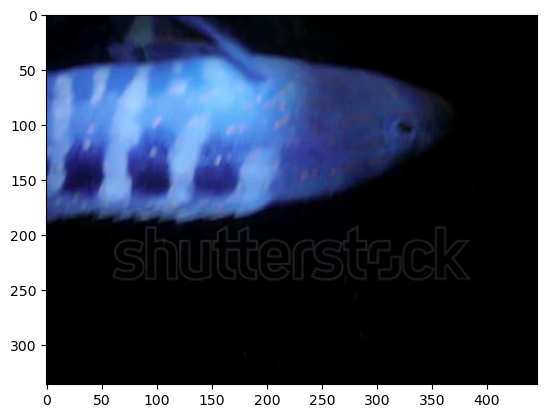

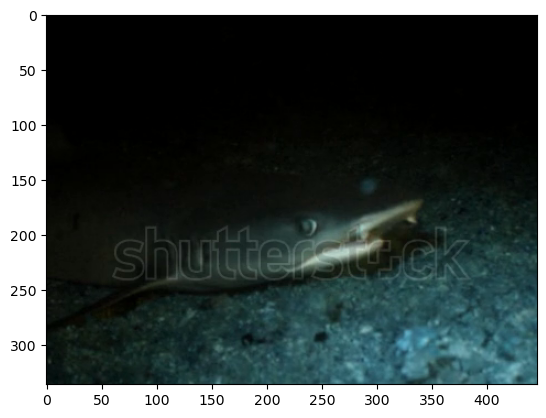

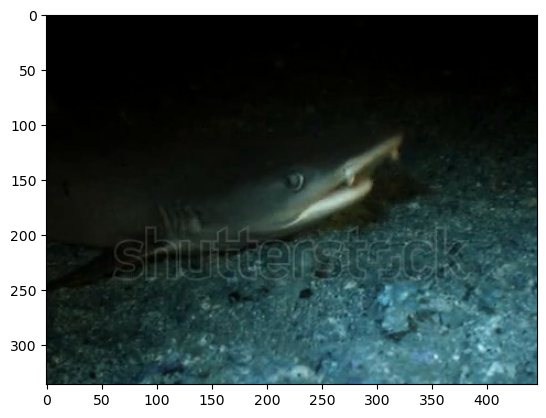

In [7]:
for frame in frames:
    plt.imshow(frame)
    plt.show()

#### Image DataLoader

In [8]:
image_data_loader = TarOrFolderImageLoader(image_folder = image_data_path)

for fname in os.listdir(image_data_path):
    image_object = image_data_loader.open_image(image_data_path + fname)
    print(type(image_object), " Shape: ", np.array(image_object).shape)

<class 'PIL.Image.Image'>  Shape:  (478, 720, 3)
<class 'PIL.Image.Image'>  Shape:  (380, 570, 3)
<class 'PIL.Image.Image'>  Shape:  (168, 300, 3)
<class 'PIL.Image.Image'>  Shape:  (225, 225, 3)
<class 'PIL.Image.Image'>  Shape:  (3083, 2624, 3)
<class 'PIL.Image.Image'>  Shape:  (667, 1000, 3)


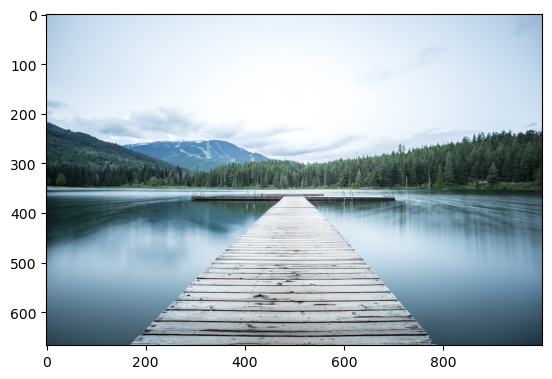

In [9]:
plt.imshow(image_object)